# A hierarchcial linear regression to fit CRISPR-Cas9 screen results

The CERES model was replicated using PyMC3 in []().
This notebook is intended to experiment with various hierarchical model architectures on a sub-sample of the real DepMap data.

## Set-up

In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
import string_functions as stringr
from common_data_processing import get_indices, make_cat, zscale_cna_by_group
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 824
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Data preparation

In [2]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)

data = data.sort_values(["hugo_symbol", "sgrna"]).reset_index(drop=True)
for col in ("hugo_symbol", "depmap_id", "sgrna"):
    data = make_cat(data, col, ordered=True, sort_cats=False)


data = zscale_cna_by_group(data, cn_max=10)

data.head(n=7)

sgrna                     replicate_id       lfc  \
0  CCACCCACAGACGCTCAGCA  42-mg-ba-311cas9_repa_p6_batch3 -0.005539   
1  CCACCCACAGACGCTCAGCA  42-mg-ba-311cas9_repb_p6_batch3  0.011213   
2  CCACCCACAGACGCTCAGCA   8-mg-ba-311cas9_repa_p5_batch3 -0.267030   
3  CCACCCACAGACGCTCAGCA   8-mg-ba-311cas9_repb_p5_batch3  0.340474   
4  CCACCCACAGACGCTCAGCA   9505bik-311cas9-repa-p6_batch3  0.584099   
5  CCACCCACAGACGCTCAGCA     a427-311cas9 rep a p4_batch3  0.042829   
6  CCACCCACAGACGCTCAGCA     a427-311cas9 rep b p4_batch3  0.114719   

   pdna_batch  passes_qc   depmap_id primary_or_metastasis  \
0           3       True  ACH-000323               Primary   
1           3       True  ACH-000323               Primary   
2           3       True  ACH-000137               Primary   
3           3       True  ACH-000137               Primary   
4           3       True  ACH-001999                   NaN   
5           3       True  ACH-000757                   NaN   
6           3       True  ACH-000757                   NaN   

                  lineage lineage_subtype kras_mutation  ...   gene_cn  \
0  central_nervous_system          glioma            WT  ...  1.192006   
1  central_nervous_system          glioma            WT  ...  1.192006   
2  central_nervous_system          glioma            WT  ...  1.653166   
3  central_nervous_system          glioma            WT  ...  1.653166   
4                pancreas        exocrine          G12V  ...  1.128780   
5                    lung           NSCLC          G12D  ...  1.145699   
6                    lung           NSCLC          G12D  ...  1.145699   

   n_muts any_deleterious  variant_classification  is_deleterious  \
0       0           False                     NaN             NaN   
1       0           False                     NaN             NaN   
2       0           False                     NaN             NaN   
3       0           False                     NaN             NaN   
4       0           False                     NaN             NaN   
5       1           False                  silent           FALSE   
6       1           False                  silent           FALSE   

   is_tcga_hotspot  is_cosmic_hotspot  mutated_at_guide_location  rna_expr  \
0              NaN                NaN                      False  0.310340   
1              NaN                NaN                      False  0.310340   
2              NaN                NaN                      False  1.891419   
3              NaN                NaN                      False  1.891419   
4              NaN                NaN                      False  0.985500   
5            FALSE              FALSE                      False  1.555816   
6            FALSE              FALSE                      False  1.555816   

   gene_cn_z  
0  -1.139430  
1  -1.139430  
2  -0.252396  
3  -0.252396  
4  -1.261044  
5  -1.228501  
6  -1.228501  

[7 rows x 28 columns]

In [3]:
data.describe()

lfc    pdna_batch  n_alignments    chromosome     chrom_pos  \
count  60049.000000  60049.000000  60049.000000  60049.000000  6.004900e+04   
mean      -0.110098      2.861063      1.029126      8.796117  8.199159e+07   
std        0.562585      0.355663      0.168162      6.526117  6.014320e+07   
min       -4.972325      2.000000      1.000000      1.000000  7.675103e+06   
25%       -0.344279      3.000000      1.000000      3.000000  3.201892e+07   
50%       -0.033168      3.000000      1.000000      8.000000  5.977335e+07   
75%        0.218036      3.000000      1.000000     16.000000  1.375787e+08   
max        5.598174      4.000000      2.000000     20.000000  2.230033e+08   

       segment_mean    segment_cn  log2_gene_cn_p1       gene_cn  \
count  5.984300e+04  5.984300e+04     6.004900e+04  6.004900e+04   
mean   1.052517e+00  3.673521e+12     1.012354e+00  1.894709e+00   
std    8.296245e-01  3.177012e+14     2.294065e-01  4.336833e+00   
min    9.598765e-08  1.000000e+00     5.506197e-09  5.506197e-09   
25%    8.530658e-01  1.806335e+00     8.900191e-01  1.435176e+00   
50%    1.005954e+00  2.008272e+00     1.004289e+00  1.729965e+00   
75%    1.154679e+00  2.226348e+00     1.107473e+00  2.026700e+00   
max    5.460920e+01  2.747932e+16     5.797252e+00  3.283930e+02   

             n_muts      rna_expr     gene_cn_z  
count  60049.000000  60049.000000  6.004900e+04  
mean       0.097654      2.957374  1.272609e-16  
std        0.354338      2.292989  1.000008e+00  
min        0.000000      0.000000 -3.065984e+00  
25%        0.000000      0.790772 -5.710118e-01  
50%        0.000000      2.895303 -1.340551e-01  
75%        0.000000      4.698218  4.430254e-01  
max        8.000000     11.496005  1.055240e+01

In [4]:
data.shape

(60049, 28)

## EDA

In [5]:
data.columns

Index(['sgrna', 'replicate_id', 'lfc', 'pdna_batch', 'passes_qc', 'depmap_id',
       'primary_or_metastasis', 'lineage', 'lineage_subtype', 'kras_mutation',
       'genome_alignment', 'n_alignments', 'hugo_symbol', 'chromosome',
       'chrom_pos', 'segment_mean', 'segment_cn', 'log2_gene_cn_p1', 'gene_cn',
       'n_muts', 'any_deleterious', 'variant_classification', 'is_deleterious',
       'is_tcga_hotspot', 'is_cosmic_hotspot', 'mutated_at_guide_location',
       'rna_expr', 'gene_cn_z'],
      dtype='object')

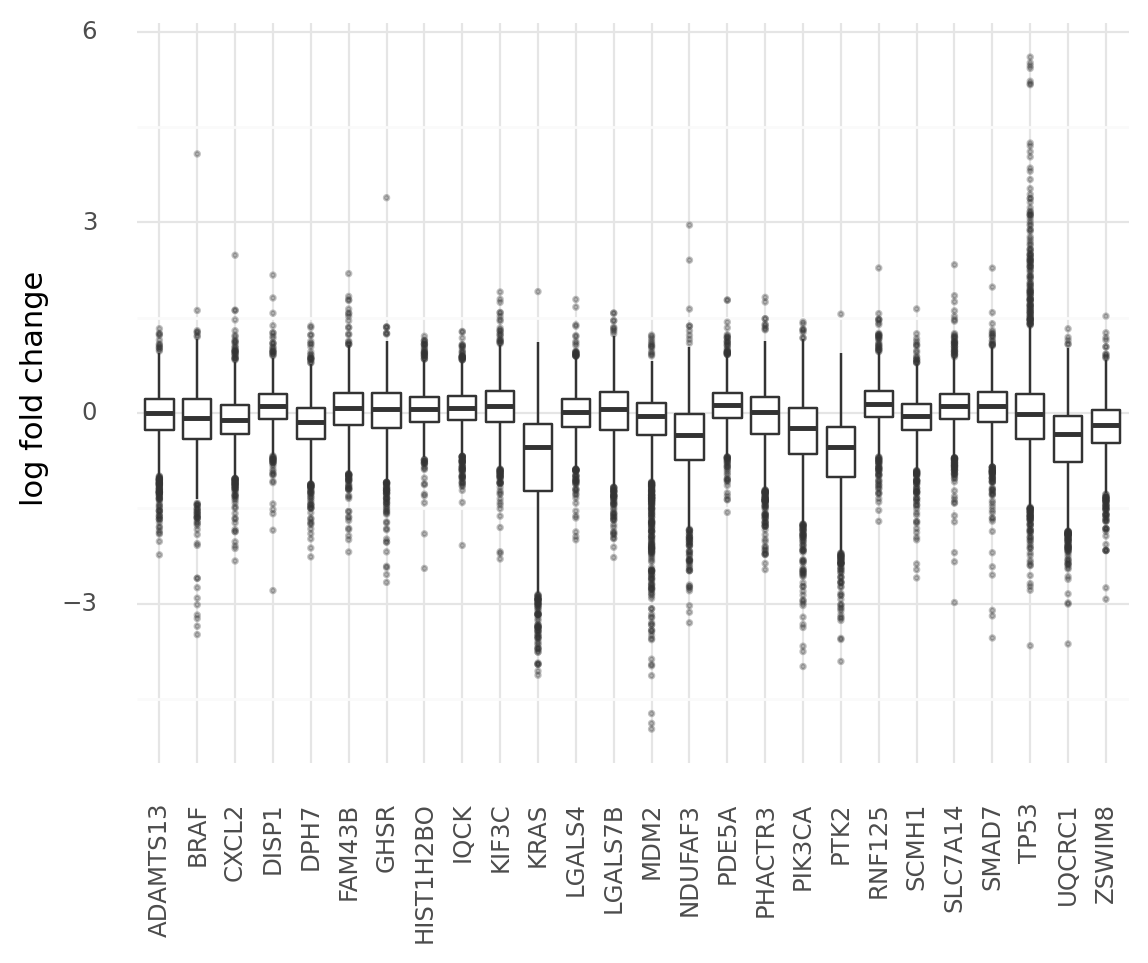

<ggplot: (8727579323573)>

In [6]:
(
    gg.ggplot(data, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_boxplot(outlier_alpha=0.3, outlier_size=0.5)
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1))
    + gg.labs(x=None, y="log fold change")
)

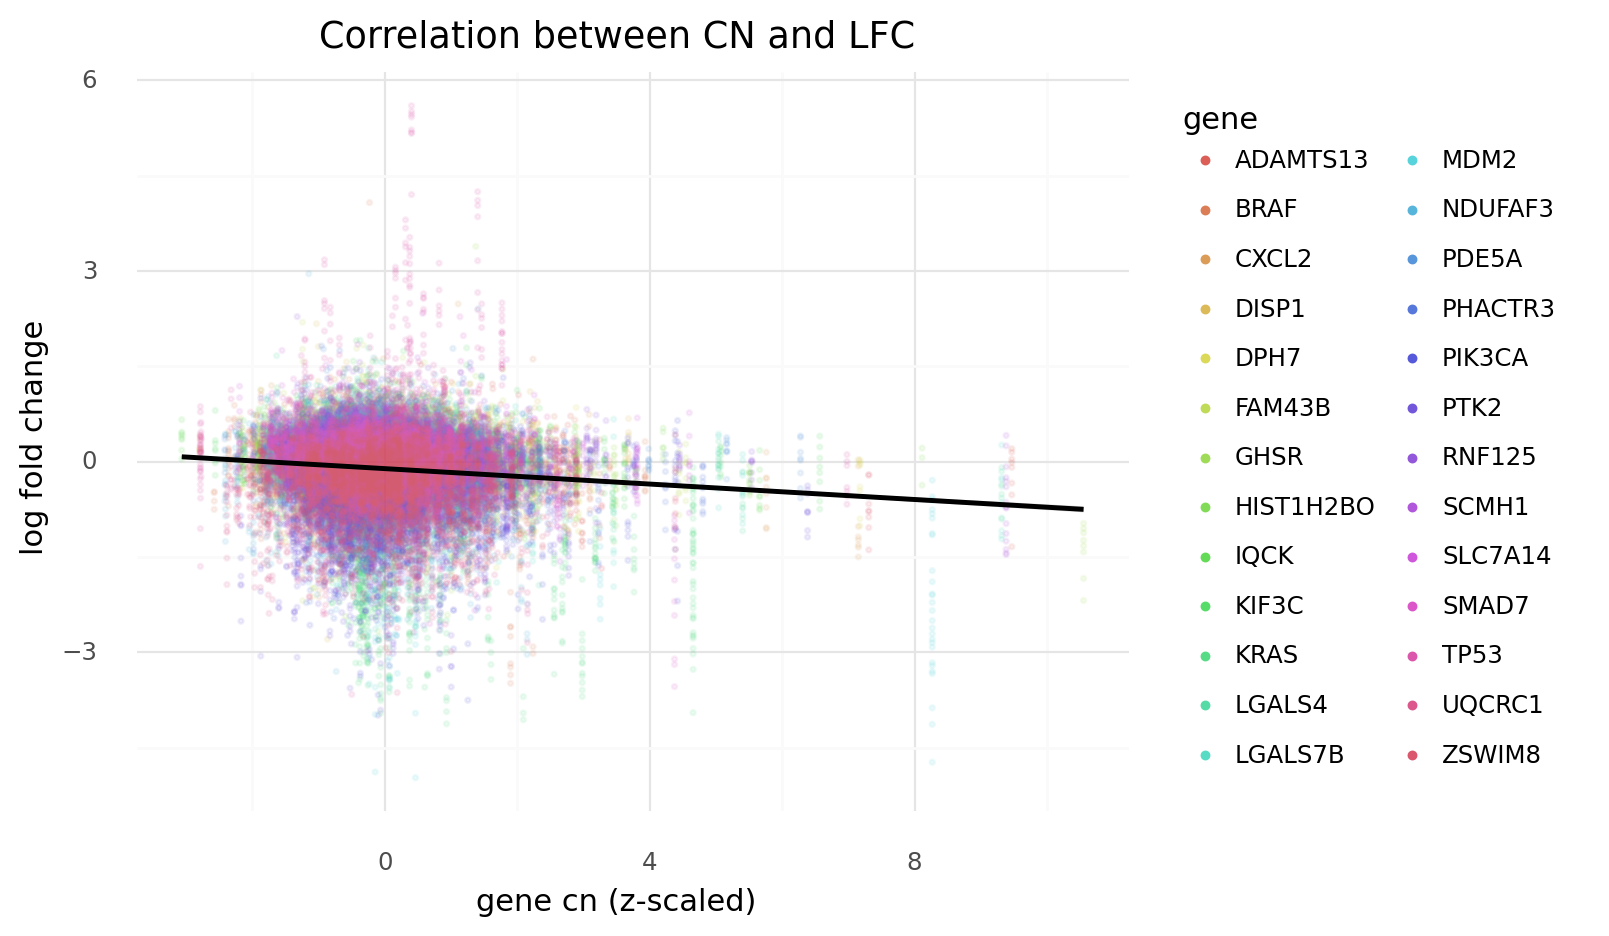

<ggplot: (8727487816701)>

In [7]:
p = (
    gg.ggplot(data, gg.aes(x="gene_cn_z", y="lfc"))
    + gg.geom_point(gg.aes(color="hugo_symbol"), alpha=0.1, size=0.5)
    + gg.geom_smooth()
    + gg.scale_color_discrete(
        guide=gg.guide_legend(override_aes={"size": 1, "alpha": 1})
    )
    + gg.labs(
        x="gene cn (z-scaled)",
        y="log fold change",
        title="Correlation between CN and LFC",
        color="gene",
    )
)
p

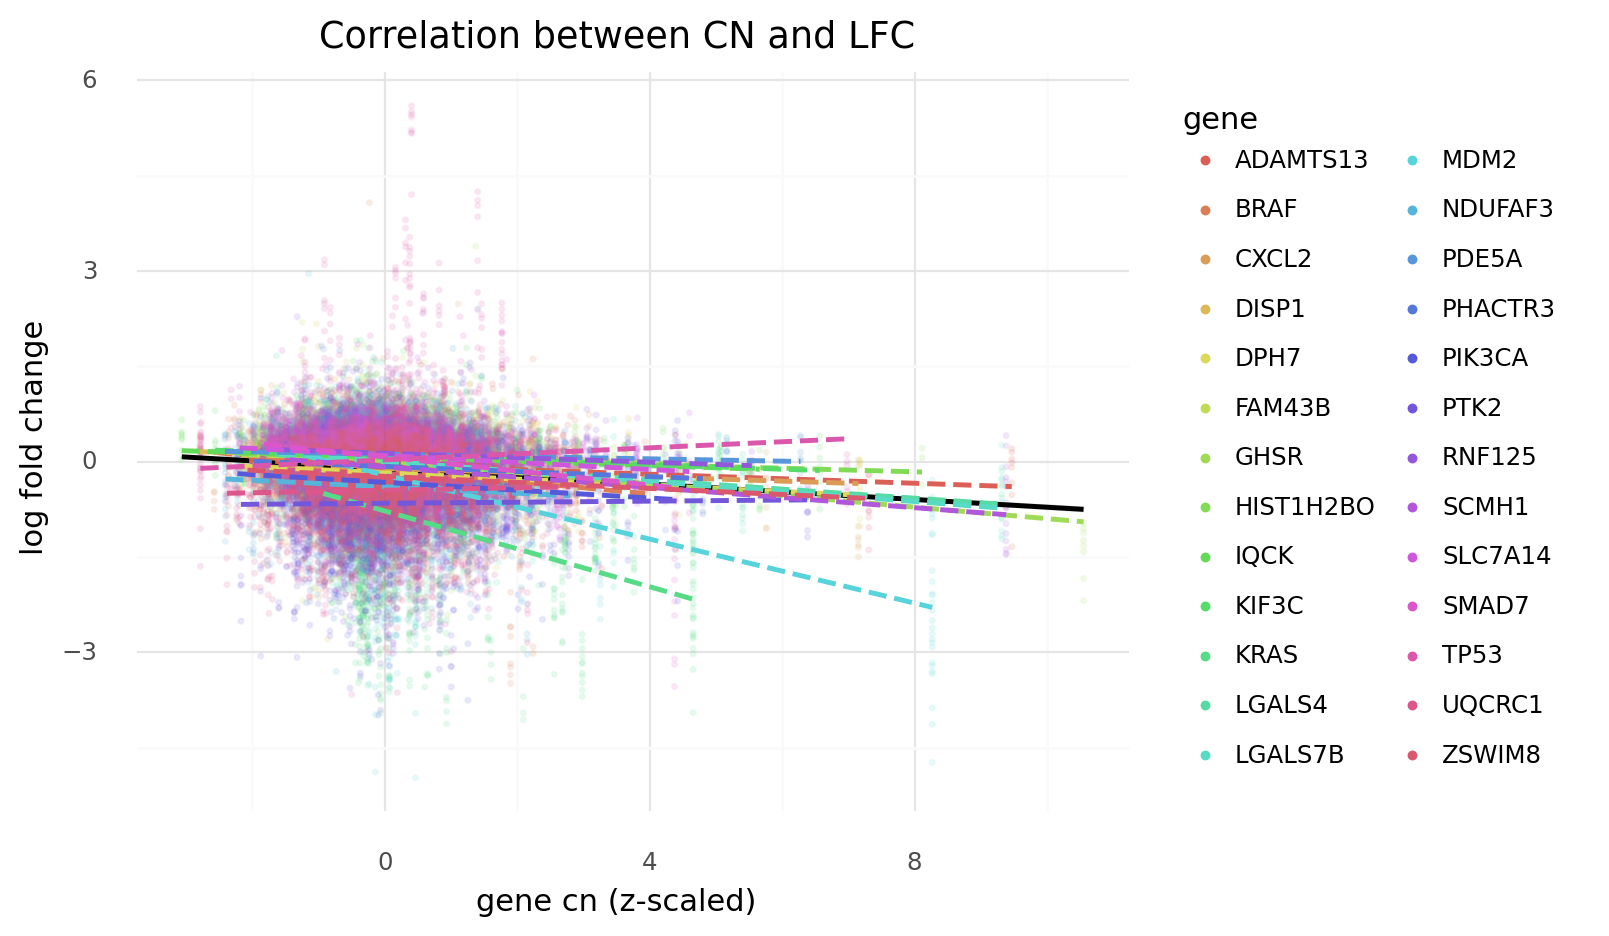

<ggplot: (8727496995482)>

In [8]:
(
    p
    + gg.geom_smooth(
        gg.aes(color="hugo_symbol"),
        linetype="--",
        alpha=0.5,
        se=False,
        show_legend=False,
    )
)

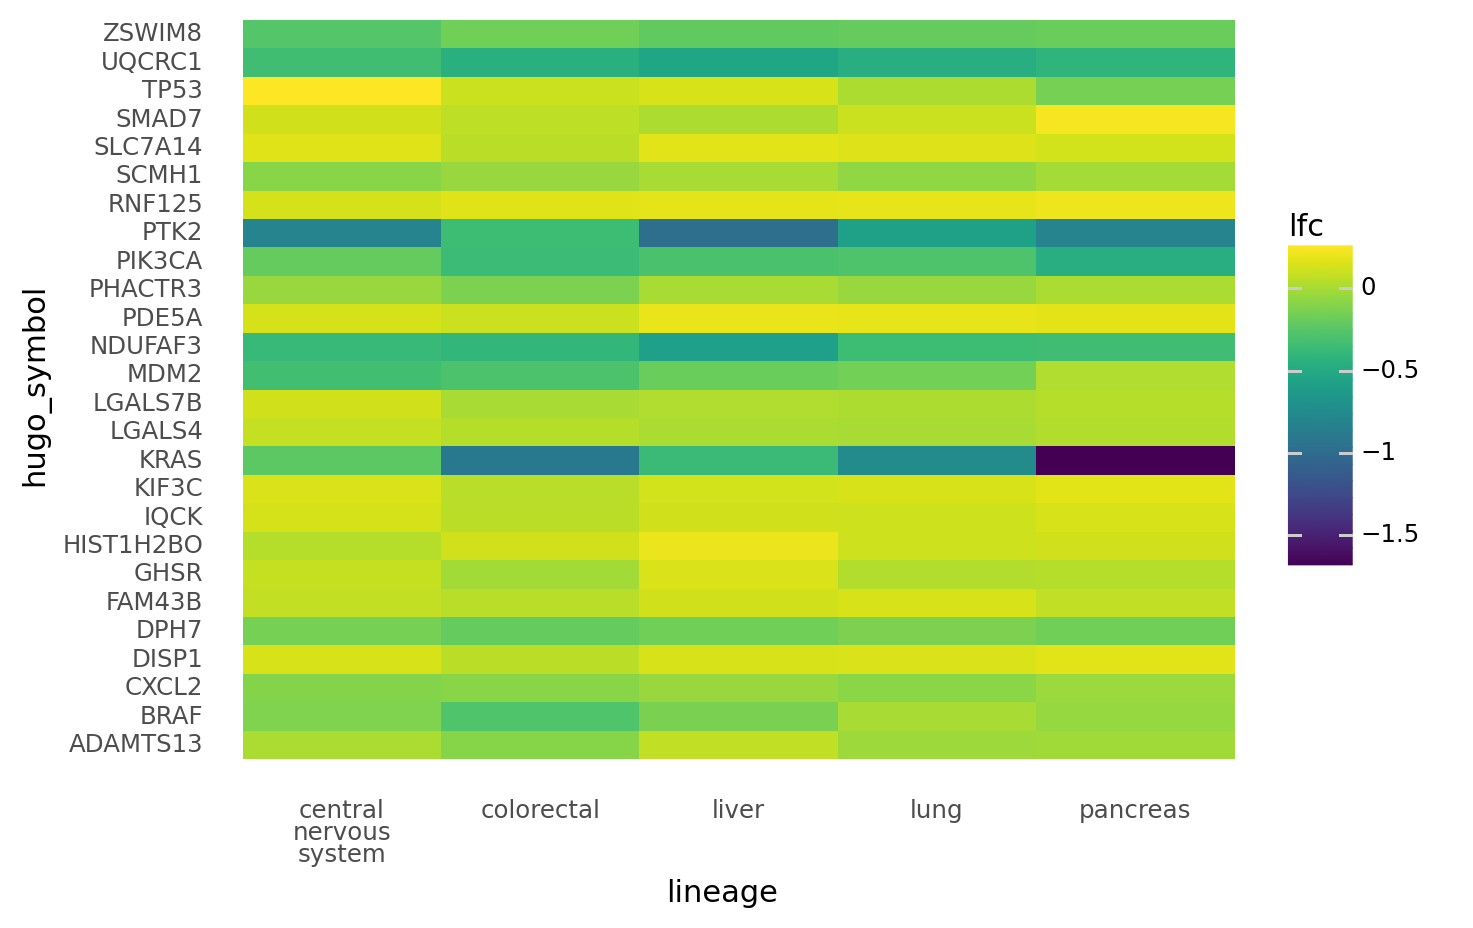

<ggplot: (8727486981852)>

In [9]:
d = data.groupby(["lineage", "hugo_symbol"]).mean().reset_index(drop=False)
d["lineage"] = stringr.str_replace(d["lineage"], "_", " ")
d["lineage"] = stringr.str_wrap(d["lineage"], width=10)

(
    gg.ggplot(d, gg.aes(x="lineage", y="hugo_symbol", fill="lfc"))
    + gg.geom_tile()
    + gg.scale_x_discrete(expand=(0, 0.5, 0, 0.5))
    + gg.scale_y_discrete(expand=(0, 0.5, 0, 0.5))
)

In [10]:
data.head()

sgrna                     replicate_id       lfc  \
0  CCACCCACAGACGCTCAGCA  42-mg-ba-311cas9_repa_p6_batch3 -0.005539   
1  CCACCCACAGACGCTCAGCA  42-mg-ba-311cas9_repb_p6_batch3  0.011213   
2  CCACCCACAGACGCTCAGCA   8-mg-ba-311cas9_repa_p5_batch3 -0.267030   
3  CCACCCACAGACGCTCAGCA   8-mg-ba-311cas9_repb_p5_batch3  0.340474   
4  CCACCCACAGACGCTCAGCA   9505bik-311cas9-repa-p6_batch3  0.584099   

   pdna_batch  passes_qc   depmap_id primary_or_metastasis  \
0           3       True  ACH-000323               Primary   
1           3       True  ACH-000323               Primary   
2           3       True  ACH-000137               Primary   
3           3       True  ACH-000137               Primary   
4           3       True  ACH-001999                   NaN   

                  lineage lineage_subtype kras_mutation  ...   gene_cn  \
0  central_nervous_system          glioma            WT  ...  1.192006   
1  central_nervous_system          glioma            WT  ...  1.192006   
2  central_nervous_system          glioma            WT  ...  1.653166   
3  central_nervous_system          glioma            WT  ...  1.653166   
4                pancreas        exocrine          G12V  ...  1.128780   

   n_muts any_deleterious  variant_classification  is_deleterious  \
0       0           False                     NaN             NaN   
1       0           False                     NaN             NaN   
2       0           False                     NaN             NaN   
3       0           False                     NaN             NaN   
4       0           False                     NaN             NaN   

   is_tcga_hotspot  is_cosmic_hotspot  mutated_at_guide_location  rna_expr  \
0              NaN                NaN                      False  0.310340   
1              NaN                NaN                      False  0.310340   
2              NaN                NaN                      False  1.891419   
3              NaN                NaN                      False  1.891419   
4              NaN                NaN                      False  0.985500   

   gene_cn_z  
0  -1.139430  
1  -1.139430  
2  -0.252396  
3  -0.252396  
4  -1.261044  

[5 rows x 28 columns]

## Modeling

### Model 1. Hierarchical model by gene with no other variables

$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_{g} \\
\alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\mu_\alpha \sim \mathcal{N}(0, 5) \\
\sigma_\alpha \sim \text{HalfNormal}(0, 5) \\
\sigma \sim \text{HalfNormal}(0, 5)
$

In [11]:
gene_idx = get_indices(data, "hugo_symbol")
num_genes = data["hugo_symbol"].nunique()
with pm.Model() as m1:
    σ_α = pm.HalfNormal("σ_α", 5.0)
    μ_α = pm.Normal("μ_α", 0, 5)

    α_g = pm.Normal("α_g", μ_α, σ_α, shape=num_genes)
    μ = pm.Deterministic("μ", α_g[gene_idx])
    σ = pm.HalfNormal("σ", 5.0)

    y = pm.Normal("y", mu=μ, sigma=σ, observed=data.lfc)

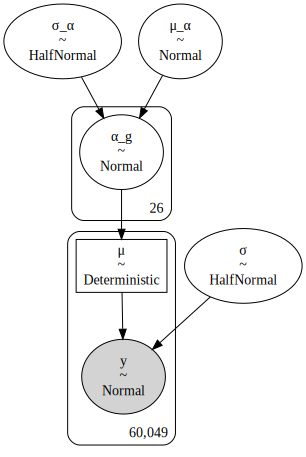

In [12]:
pm.model_to_graphviz(m1)

In [13]:
m1_cache_dir = pymc3_cache_dir / "subset_speclet_m1"

m1_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=m1,
    num_mcmc=1000,
    tune=1000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=pymc3_cache_dir / m1_cache_dir,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 40000},
)

Loading cached trace and posterior sample...


In [14]:
m1_az = pmhelp.samples_to_arviz(model=m1, res=m1_sampling_results)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


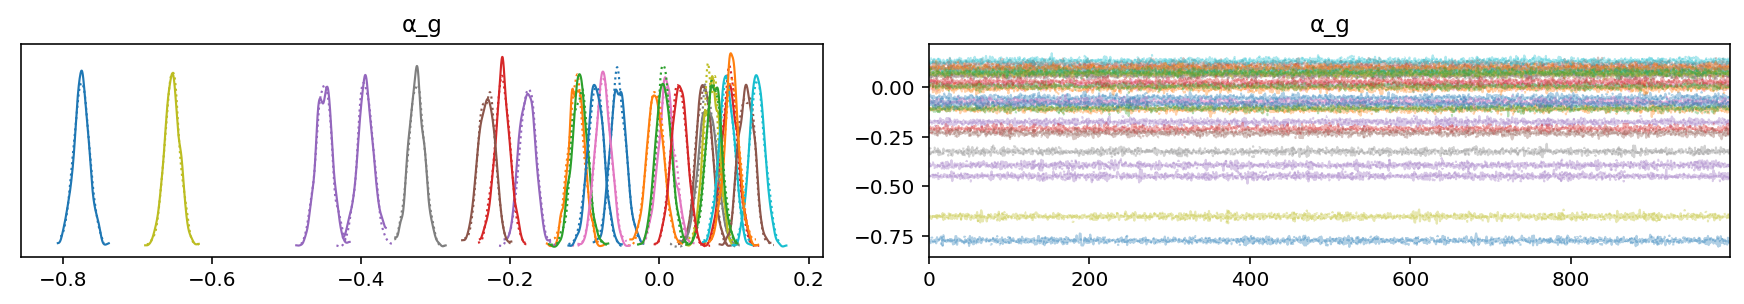

In [15]:
az.plot_trace(m1_az, var_names="α_g", compact=True)
plt.show()

### Model 2. Add a layer for gene above sgRNA

$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_s \\
\quad \alpha_s \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \mu_\alpha = g_\alpha \\
\qquad \quad g_\alpha \sim \mathcal{N}(\mu_{g_\alpha}, \sigma_{g_\alpha}) \\
\qquad \qquad \mu_{g_\alpha} \sim \mathcal{N}(0, 5) \\
\qquad \qquad \sigma_{g_\alpha} \sim \text{Exp}(1) \\
\qquad \sigma_\alpha \sim \text{Exp}(\sigma_{\sigma_\alpha}) \\
\qquad \quad \sigma_{\sigma_\alpha} \sim \text{Exp}(1) \\
\sigma \sim \text{HalfNormal}(3)
$


In [16]:
num_sgrnas = data["sgrna"].nunique()
num_genes = data["hugo_symbol"].nunique()
print(f"{num_sgrnas} sgRNAs from {num_genes} genes")

sgrna_idx = get_indices(data, "sgrna")

sgrna_to_gene_map = data[["sgrna", "hugo_symbol"]].drop_duplicates()
gene_idx = get_indices(sgrna_to_gene_map, "hugo_symbol")

103 sgRNAs from 26 genes


In [17]:
with pm.Model() as m2:
    μ_g = pm.Normal("μ_g", 0, 5)
    σ_g = pm.Exponential("σ_g", 1)

    g_s = pm.Normal("g_s", μ_g, σ_g, shape=num_genes)

    μ_α_s = pm.Deterministic("μ_α_s", g_s[gene_idx])
    σ_α_s = pm.Exponential("σ_α_s", 1)

    α_s = pm.Normal("α_s", μ_α_s, σ_α_s, shape=num_sgrnas)

    μ = pm.Deterministic("μ", α_s[sgrna_idx])
    σ = pm.HalfNormal("σ", 5)

    y = pm.Normal("y", μ, σ, observed=data.lfc)

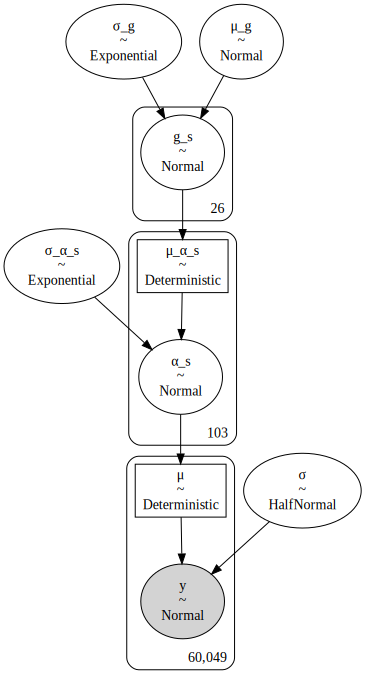

In [18]:
pm.model_to_graphviz(m2)

In [19]:
m2_cache_dir = pymc3_cache_dir / "subset_speclet_m2"

m2_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=m2,
    num_mcmc=2000,
    tune=4000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=pymc3_cache_dir / m2_cache_dir,
    force=False,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 40000, "target_accept": 0.9},
)

Loading cached trace and posterior sample...


In [20]:
m2_az = pmhelp.samples_to_arviz(model=m2, res=m2_sampling_results)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


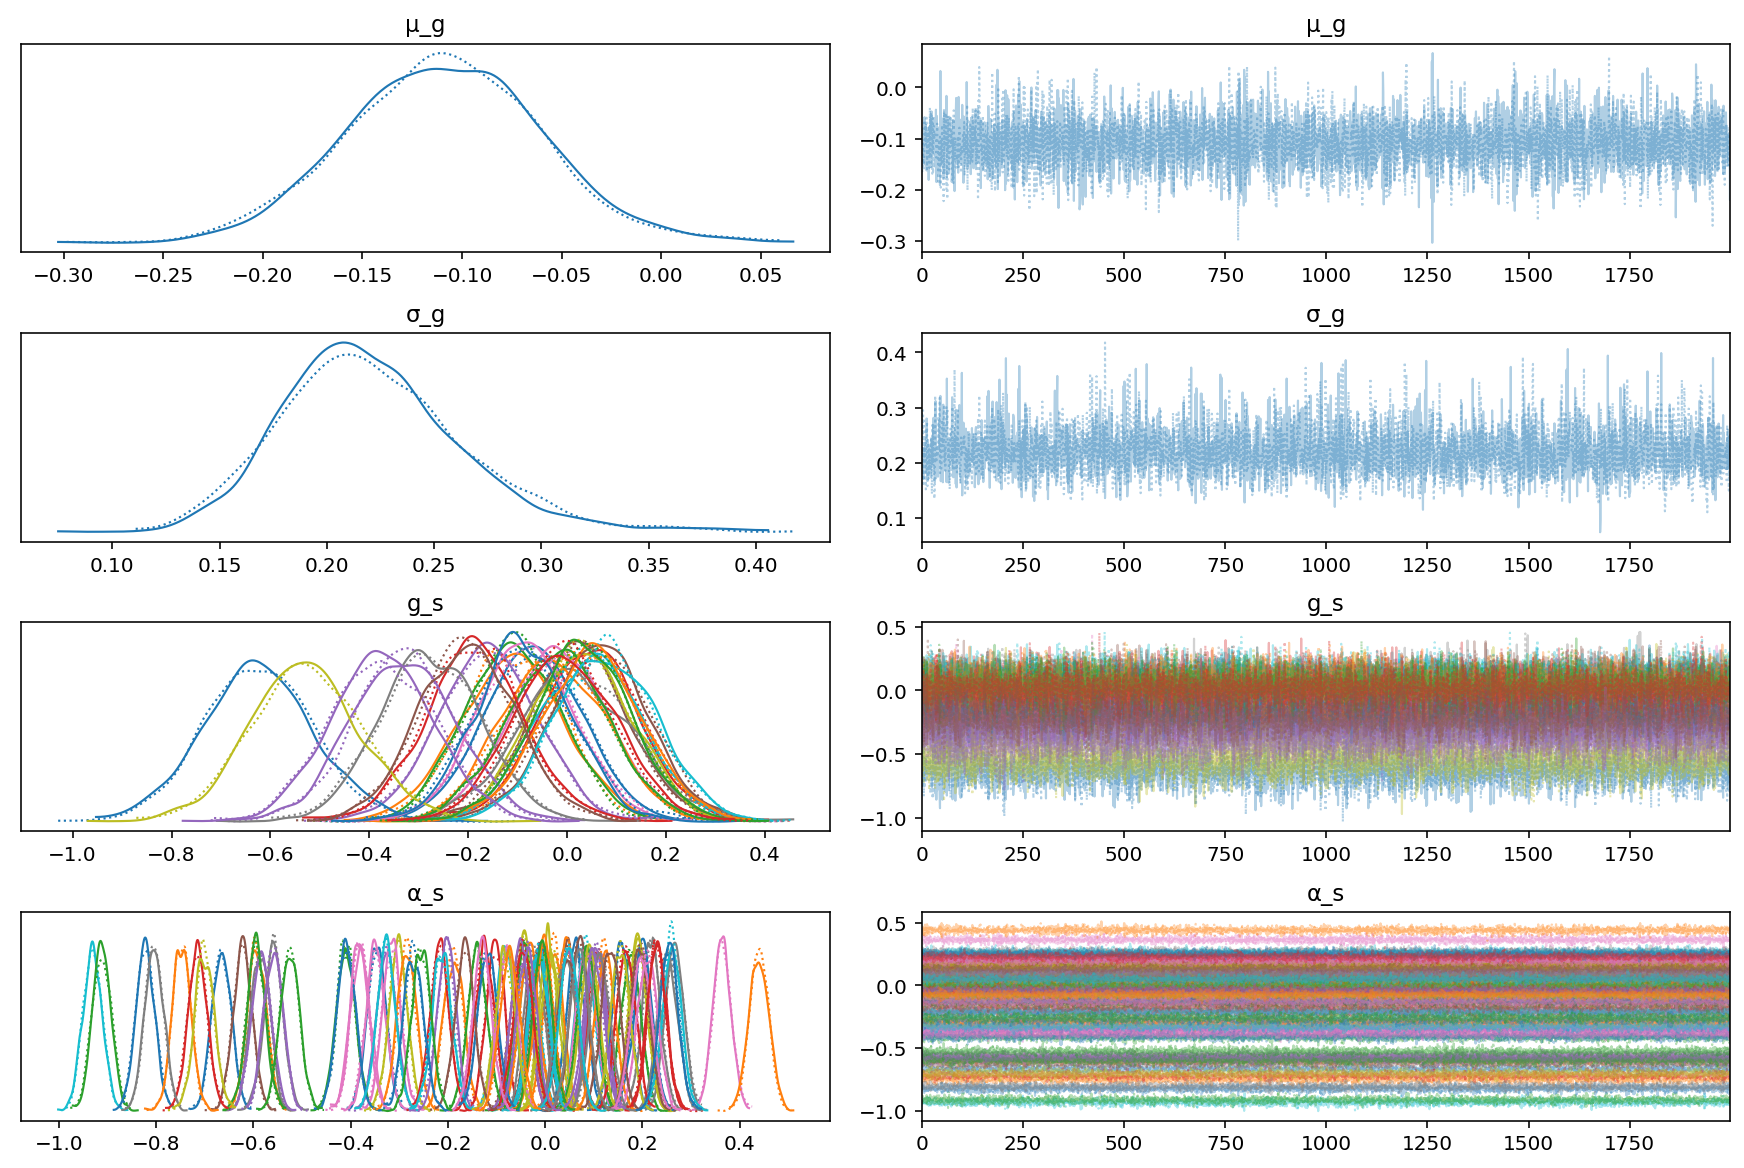

In [21]:
az.plot_trace(m2_az, var_names=["μ_g", "σ_g", "g_s", "α_s"], compact=True)
plt.show()

In [22]:
az.summary(m2_az, var_names=["μ_g", "σ_g", "σ_α_s"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ_g   -0.109  0.049  -0.203   -0.020      0.001      0.0    6430.0  5641.0   
σ_g    0.221  0.043   0.145    0.302      0.001      0.0    4227.0  4212.0   
σ_α_s  0.228  0.019   0.194    0.264      0.000      0.0    5461.0  5341.0   

       ess_bulk  ess_tail  r_hat  
μ_g      6415.0    3021.0    1.0  
σ_g      4158.0    3118.0    1.0  
σ_α_s    5560.0    3564.0    1.0

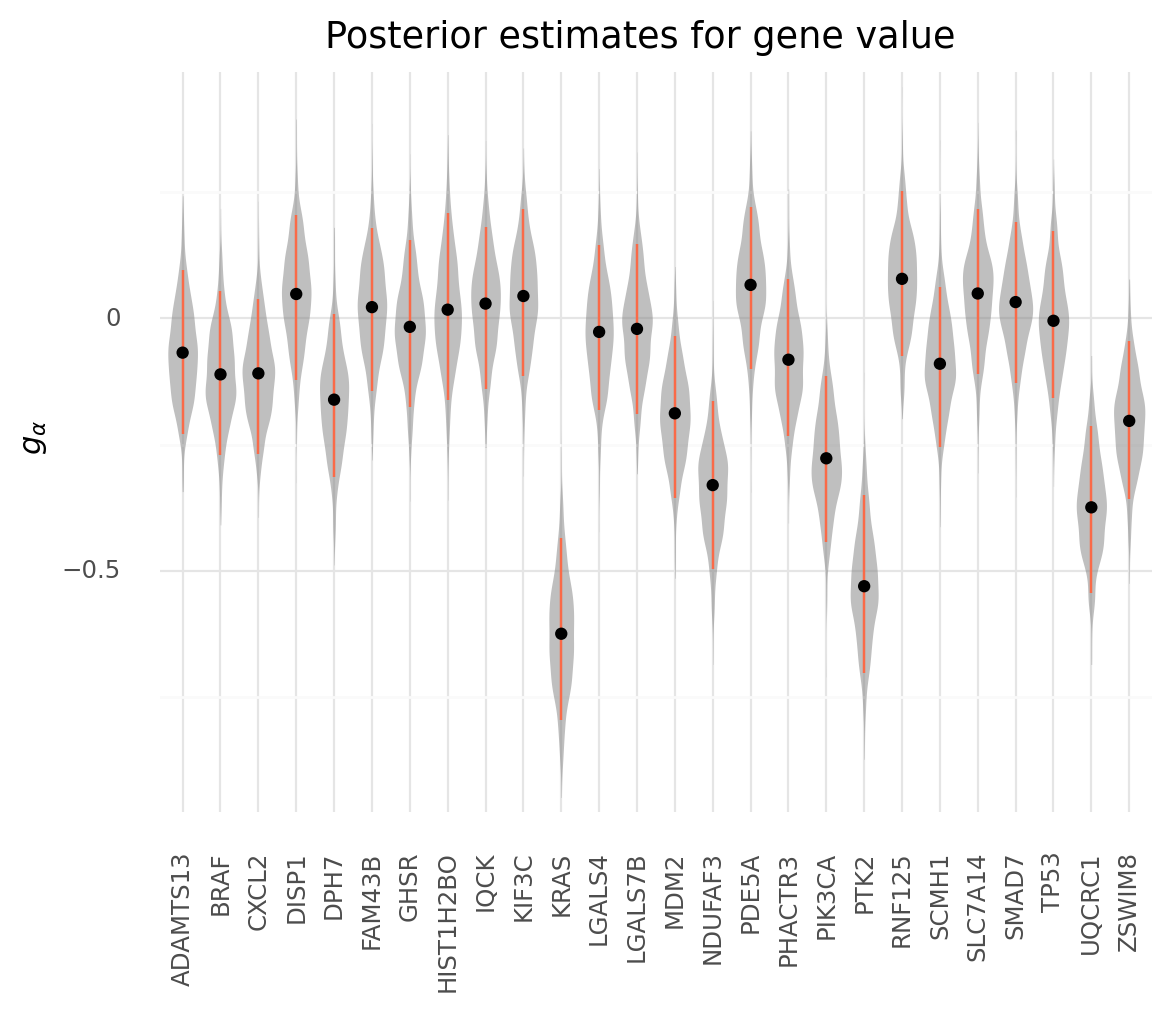

<ggplot: (8727265671349)>

In [23]:
g_alpha_post = pd.DataFrame(np.asarray(m2_az.posterior["g_s"]).reshape(-1, num_genes))
ordered_genes = (
    sgrna_to_gene_map.sort_values("hugo_symbol").hugo_symbol.drop_duplicates().to_list()
)
g_alpha_post.columns = ordered_genes
g_alpha_post = g_alpha_post.melt(var_name="hugo_symbol", value_name="value")

g_alpha_summary = az.summary(m2_az, var_names="g_s", kind="stats", hdi_prob=0.89)
g_alpha_summary["hugo_symbol"] = ordered_genes

point_color = "#FA6A48"
(
    gg.ggplot(g_alpha_post.sample(frac=0.25), gg.aes(x="hugo_symbol", y="value"))
    + gg.geom_violin(color=None, fill="grey", alpha=0.5)
    + gg.geom_linerange(
        gg.aes(x="hugo_symbol", y="mean", ymin="hdi_5.5%", ymax="hdi_94.5%"),
        data=g_alpha_summary,
        color=point_color,
    )
    + gg.geom_point(
        gg.aes(x="hugo_symbol", y="mean"), data=g_alpha_summary, color="black"
    )
    + gg.scale_y_continuous(expand=(0.02, 0, 0.02, 0))
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(x=None, y=r"$g_\alpha$", title="Posterior estimates for gene value")
)

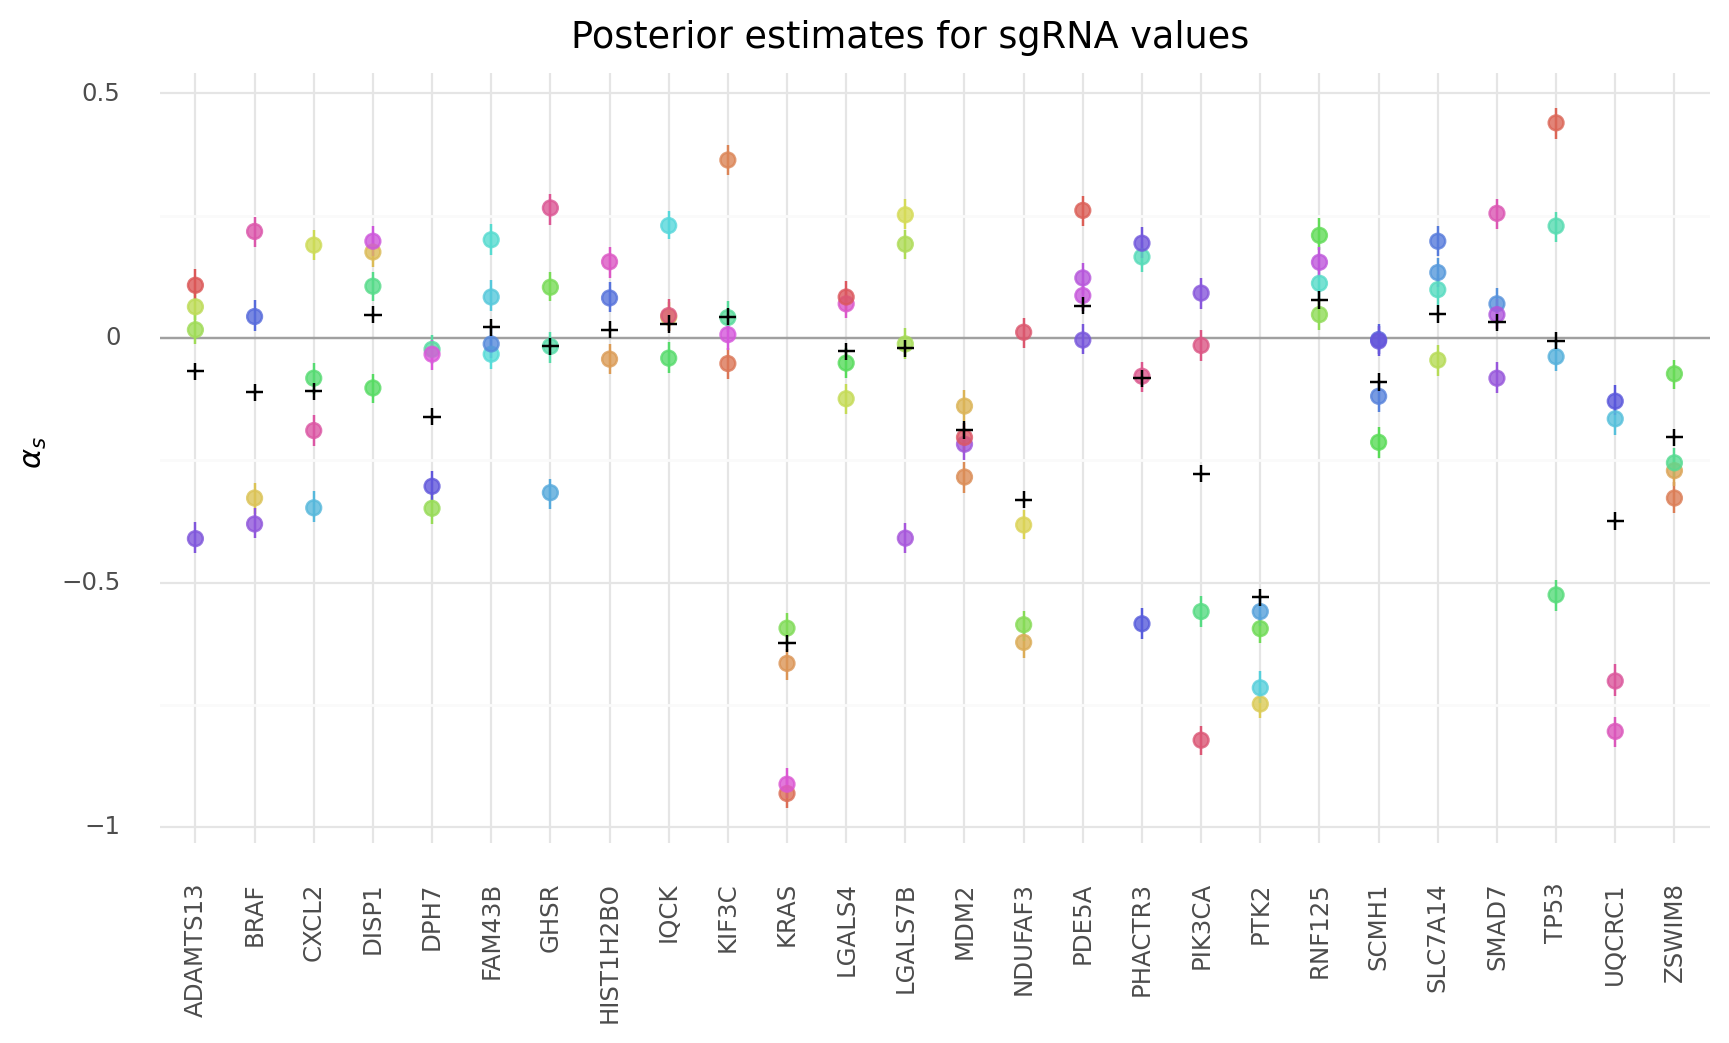

<ggplot: (8727264812704)>

In [24]:
alpha_s_summary = az.summary(m2_az, var_names="α_s", kind="stats", hdi_prob=0.89)
alpha_s_summary["sgrna"] = sgrna_to_gene_map.sgrna.to_list()
alpha_s_summary["hugo_symbol"] = sgrna_to_gene_map.hugo_symbol.to_list()

(
    gg.ggplot(alpha_s_summary, gg.aes(x="hugo_symbol"))
    + gg.geom_hline(yintercept=0, color="black", alpha=0.3)
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", color="sgrna"))
    + gg.geom_point(gg.aes(y="mean", color="sgrna"), size=2.5, alpha=0.8)
    + gg.geom_point(
        gg.aes(x="hugo_symbol", y="mean"),
        data=g_alpha_summary,
        color="black",
        shape="+",
        size=3,
    )
    + gg.scale_color_discrete(guide=None)
    + gg.theme(figure_size=(10, 5), axis_text_x=gg.element_text(angle=90))
    + gg.labs(x=None, y=r"$\alpha_s$", title="Posterior estimates for sgRNA values")
)

In [25]:
ppc_m2_arry = np.asarray(m2_az.posterior_predictive["y"]).reshape(-1, data.shape[0])
ppc_m2_summary = pd.DataFrame(
    az.hdi(ppc_m2_arry, hdi_prob=0.89), columns=("hdi_5.5%", "hdi_94.5%")
)
ppc_m2_summary["mean"] = np.mean(ppc_m2_arry, axis=0)
ppc_m2_summary = ppc_m2_summary.reset_index(drop=True).merge(
    data[["sgrna", "hugo_symbol", "lfc"]], left_index=True, right_index=True
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


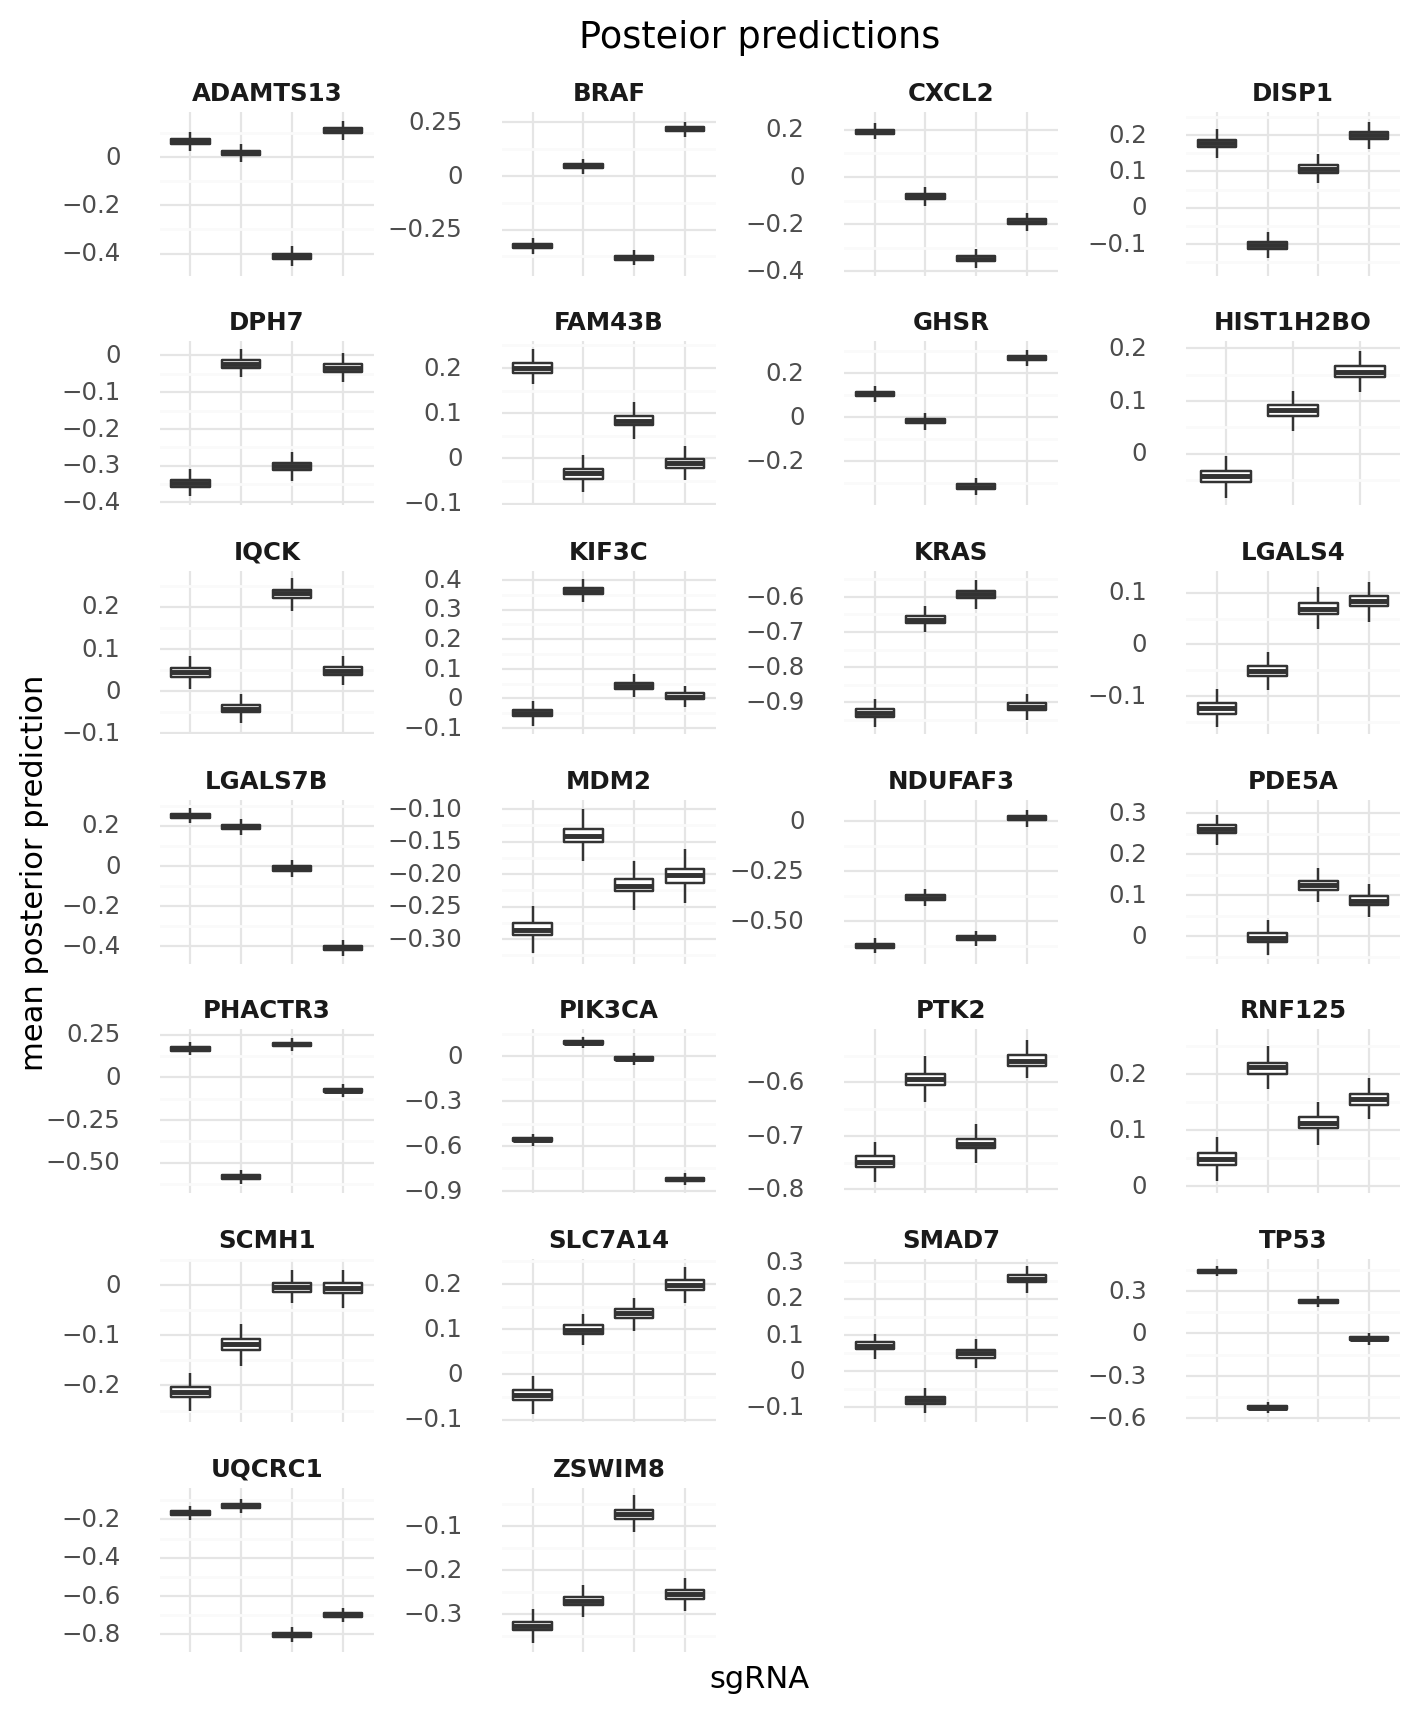

<ggplot: (8727486895336)>

In [26]:
(
    gg.ggplot(ppc_m2_summary, gg.aes(x="sgrna"))
    + gg.facet_wrap("hugo_symbol", scales="free", ncol=4)
    + gg.geom_boxplot(gg.aes(y="mean"), outlier_alpha=0)
    + gg.theme(
        axis_text_x=gg.element_blank(),
        figure_size=(8, 10),
        subplots_adjust={"hspace": 0.4, "wspace": 0.6},
        strip_text=gg.element_text(weight="bold"),
    )
    + gg.labs(x="sgRNA", y="mean posterior prediction", title="Posteior predictions")
)

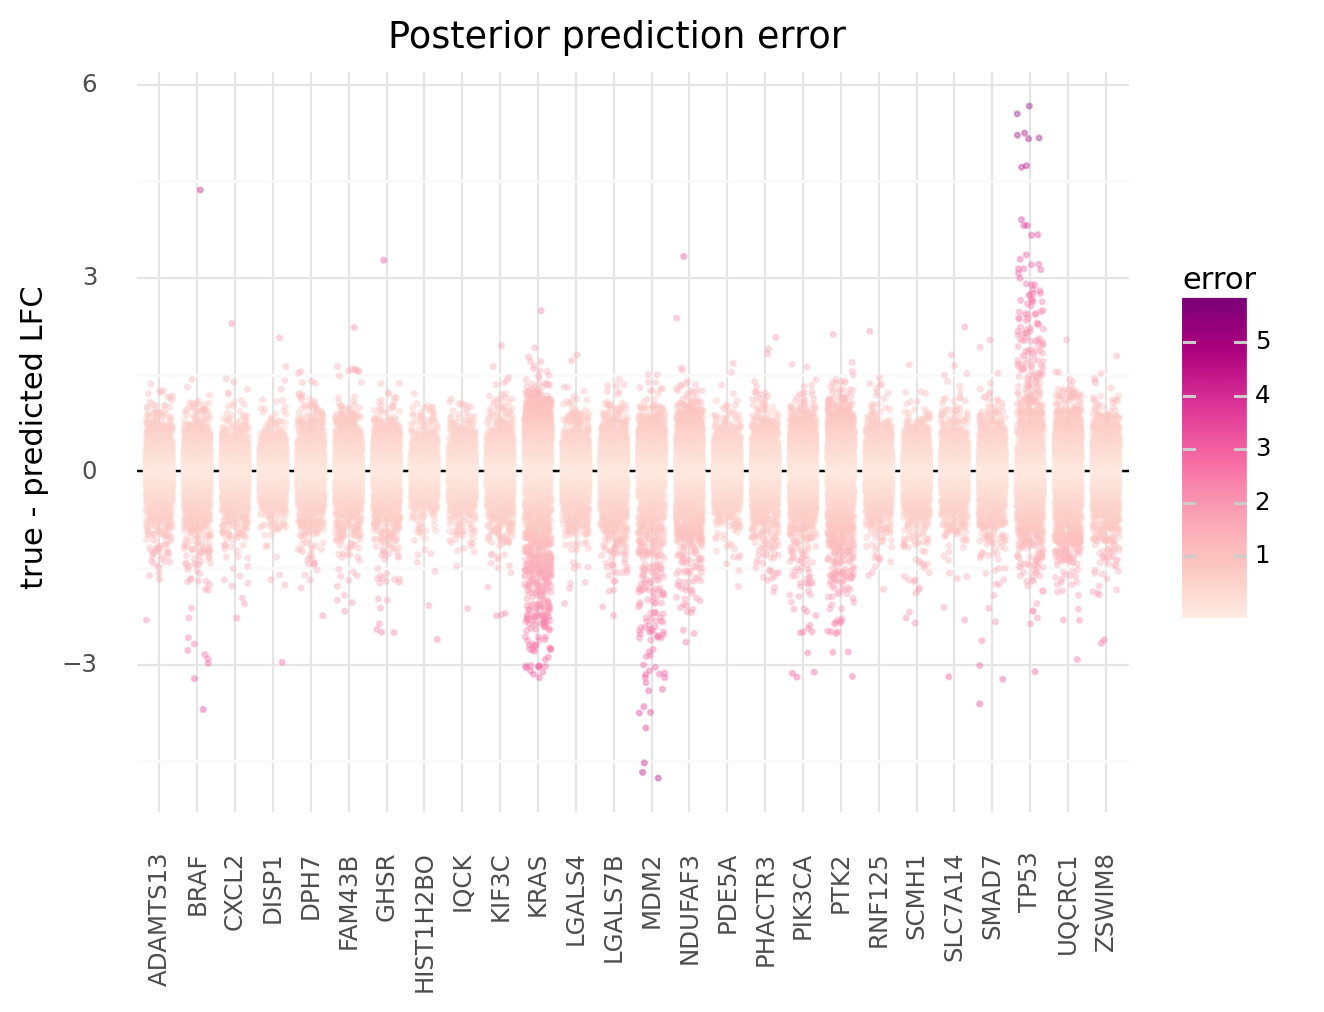

<ggplot: (8727262118843)>

In [27]:
ppc_m2_summary = ppc_m2_summary.assign(error=lambda d: d["lfc"] - d["mean"])
(
    gg.ggplot(ppc_m2_summary, gg.aes(x="hugo_symbol", y="error"))
    + gg.geom_hline(yintercept=0)
    + gg.geom_jitter(
        gg.aes(color="abs(error)"), width=0.35, height=0, size=0.5, alpha=0.3
    )
    + gg.scale_color_distiller(type="seq", palette="RdPu", direction=1)
    + gg.theme(axis_text_x=gg.element_text(rotation=90))
    + gg.labs(
        x=None,
        y="true - predicted LFC",
        title="Posterior prediction error",
        color="error",
    )
)

In [29]:
genes_with_large_error = ["KRAS", "MDM2", "PTK2", "TP53"]

for col in ["n_muts", "any_deleterious", "kras_mutation"]:
    ppc_m2_summary[col] = data[col].values

ppc2_m2_summary_mutations = ppc_m2_summary[
    ppc_m2_summary.hugo_symbol.isin(genes_with_large_error)
].reset_index()
ppc2_m2_summary_mutations["is_mutated"] = ppc2_m2_summary_mutations["n_muts"].values > 0
ppc2_m2_summary_mutations["sgrna_idx"] = get_indices(ppc2_m2_summary_mutations, "sgrna")
ppc2_m2_summary_mutations.head(5)

index  hdi_5.5%  hdi_94.5%      mean                 sgrna hugo_symbol  \
0  22737 -1.706223  -0.146976 -0.945101  AATTACTACTTGCTTCCTGT        KRAS   
1  22738 -1.661466  -0.151136 -0.947104  AATTACTACTTGCTTCCTGT        KRAS   
2  22739 -1.660307  -0.164863 -0.936319  AATTACTACTTGCTTCCTGT        KRAS   
3  22740 -1.634877  -0.131291 -0.927895  AATTACTACTTGCTTCCTGT        KRAS   
4  22741 -1.722477  -0.186996 -0.927978  AATTACTACTTGCTTCCTGT        KRAS   

        lfc     error  n_muts  any_deleterious kras_mutation  is_mutated  \
0 -0.491495  0.453606       0            False            WT       False   
1 -0.183915  0.763189       0            False            WT       False   
2 -0.044223  0.892096       0            False            WT       False   
3 -0.371057  0.556838       0            False            WT       False   
4 -2.635973 -1.707994       1            False          G12V        True   

   sgrna_idx  
0         39  
1         39  
2         39  
3         39  
4         39

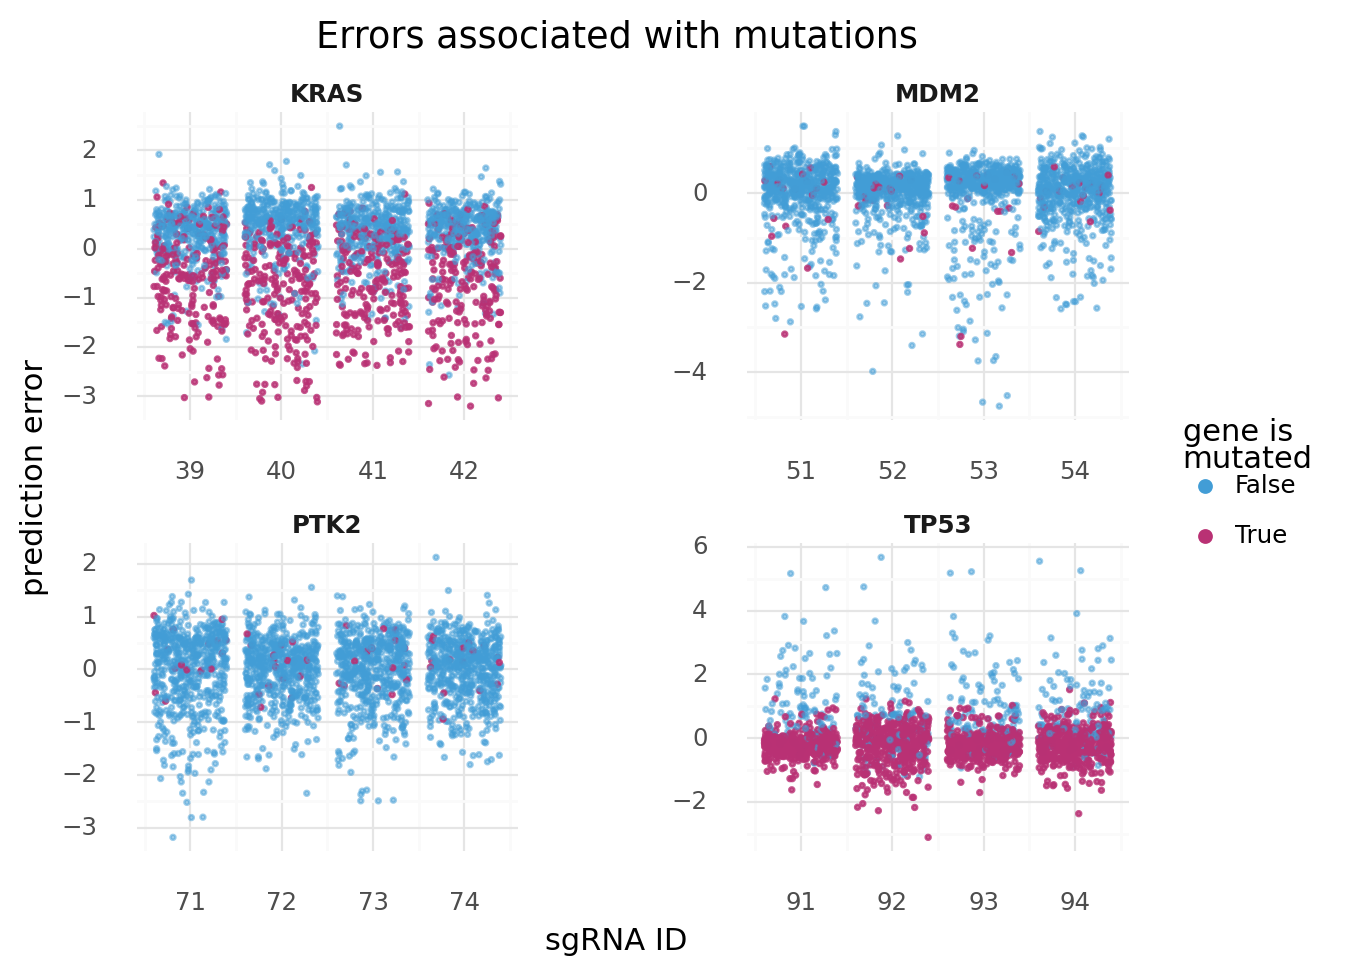

<ggplot: (8727263750666)>

In [30]:
(
    gg.ggplot(ppc2_m2_summary_mutations, gg.aes(x="sgrna_idx", y="error"))
    + gg.facet_wrap("hugo_symbol", scales="free")
    + gg.geom_jitter(gg.aes(color="is_mutated", alpha="is_mutated"), size=0.5)
    + gg.scale_color_manual(values=["#429DD6", "#B93174"])
    + gg.scale_alpha_manual(
        values=[0.5, 0.8], guide=gg.guide_legend(override_aes={"size": 2, "alpha": 1})
    )
    + gg.theme(
        subplots_adjust={"hspace": 0.4, "wspace": 0.6},
        strip_text=gg.element_text(weight="bold"),
    )
    + gg.labs(
        x="sgRNA ID",
        y="prediction error",
        title="Errors associated with mutations",
        color="gene is\nmutated",
        alpha="gene is\nmutated",
    )
)

---

In [31]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1.55 minutes


In [32]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-15

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-162.o2.rc.hms.harvard.edu

Git branch: data-subset-model

re        : 2.2.1
pymc3     : 3.9.3
seaborn   : 0.11.1
pandas    : 1.2.0
theano    : 1.0.5
arviz     : 0.10.0
matplotlib: 3.3.3
plotnine  : 0.7.1
numpy     : 1.19.5

